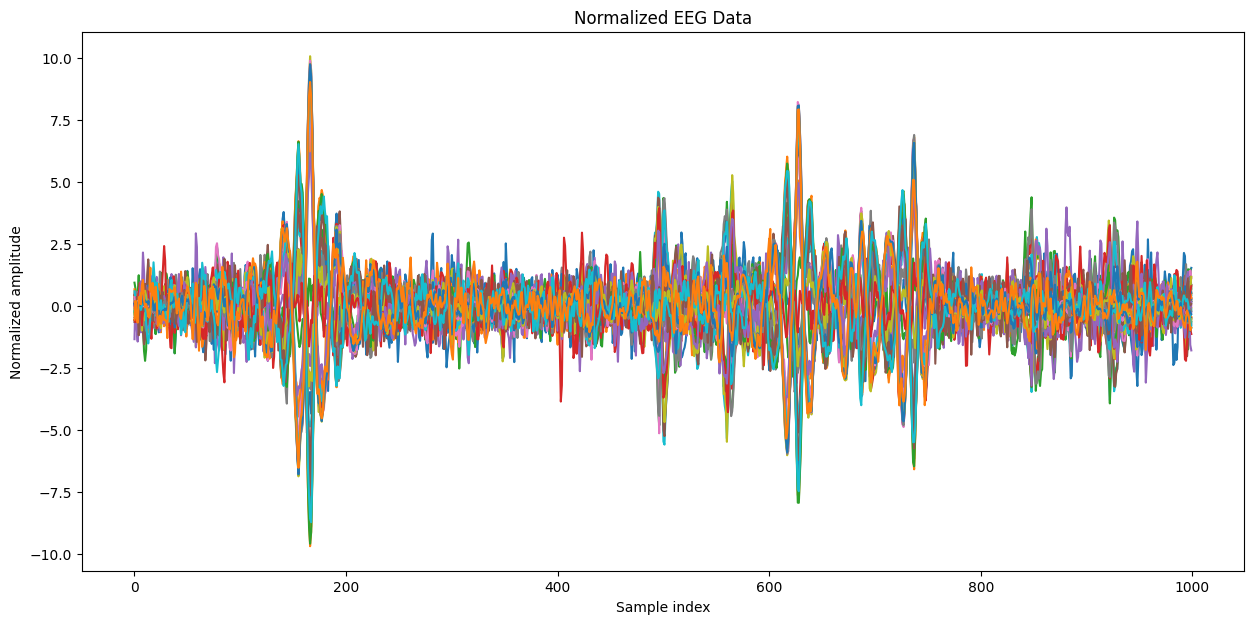

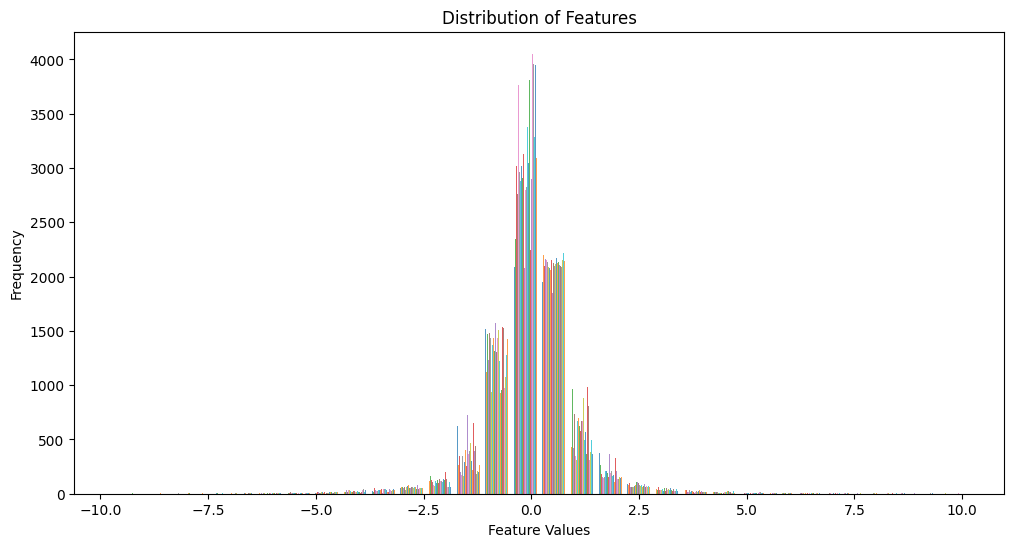

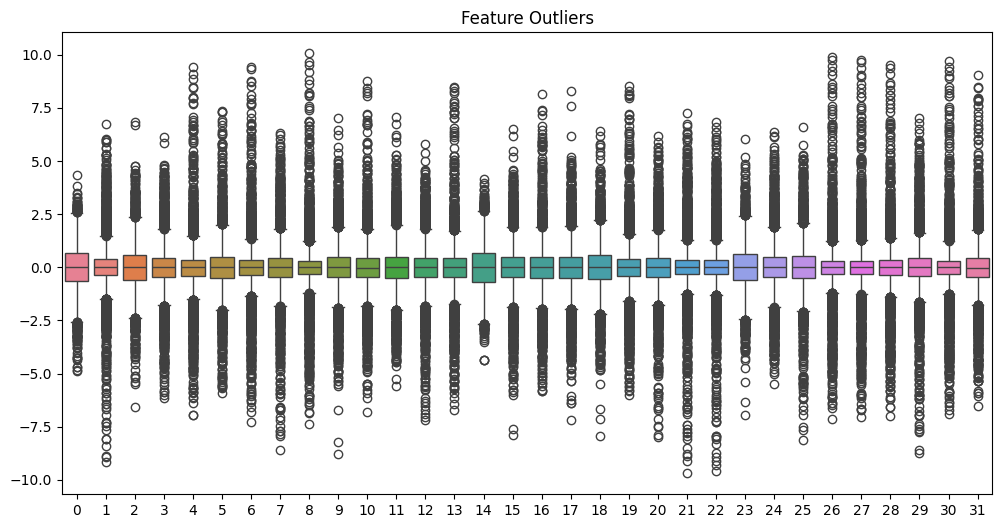

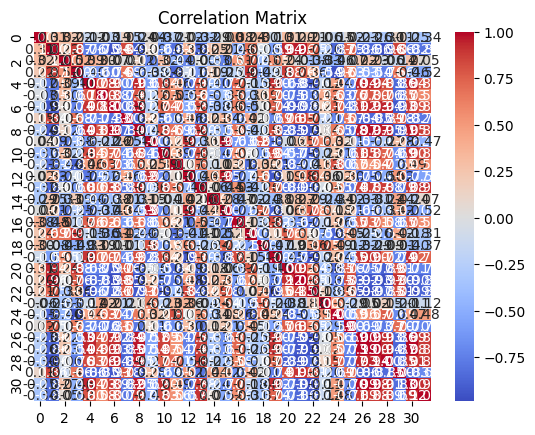

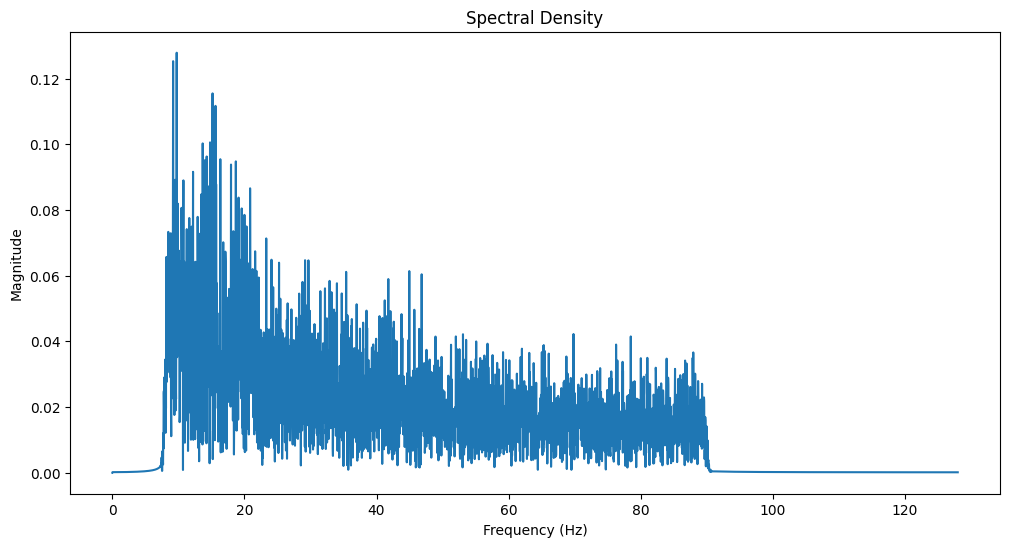

<ipython-input-10-1764b1eaf694>:73: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


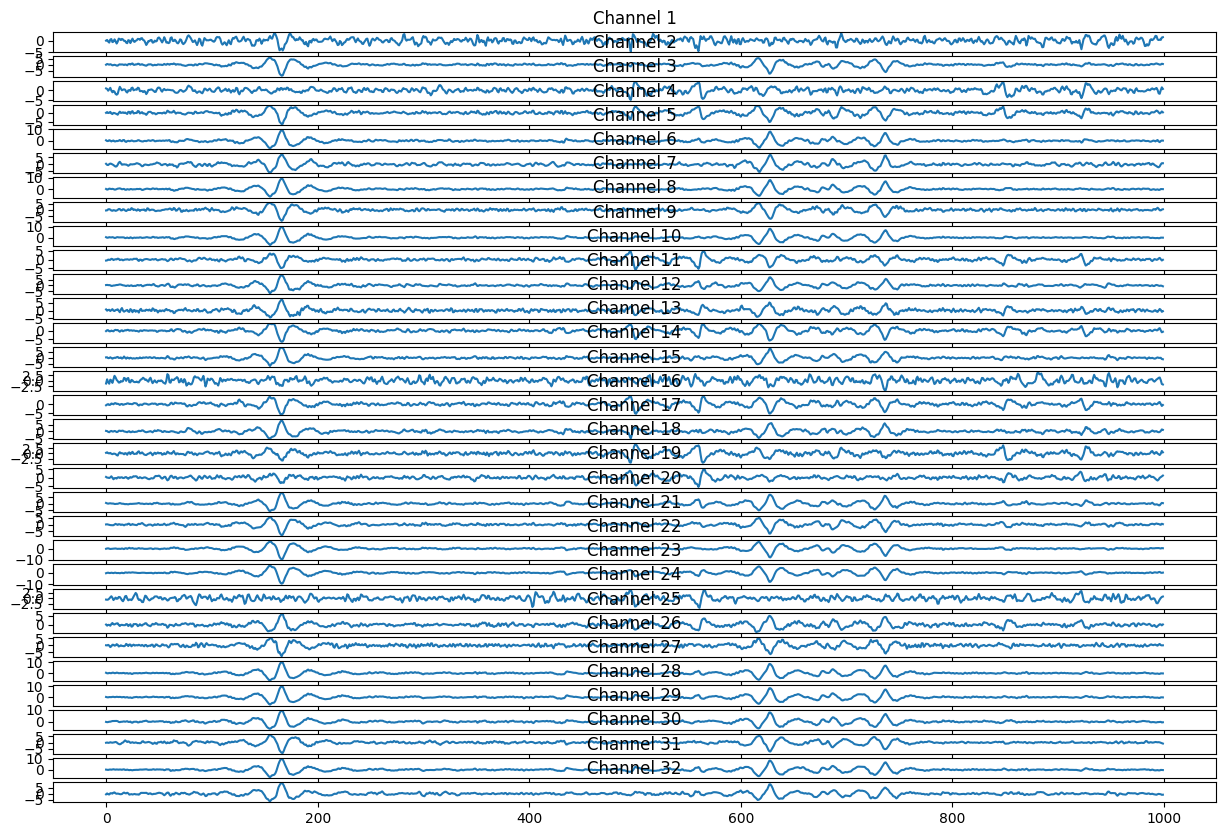

Timesteps do not evenly divide the number of features. Adjusting by padding...
Epoch 1/50
202/202 [==============================] - 20s 55ms/step - loss: 1.6701 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 2/50
202/202 [==============================] - 10s 51ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 3/50
202/202 [==============================] - 11s 52ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 4/50
202/202 [==============================] - 11s 55ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 5/50
202/202 [==============================] - 10s 50ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 6/50
202/202 [==============================] - 10s 50ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 7/50
202/202 [==============================] - 11s 56ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 8/50
202/202 [==============================] - 10s 50ms/s

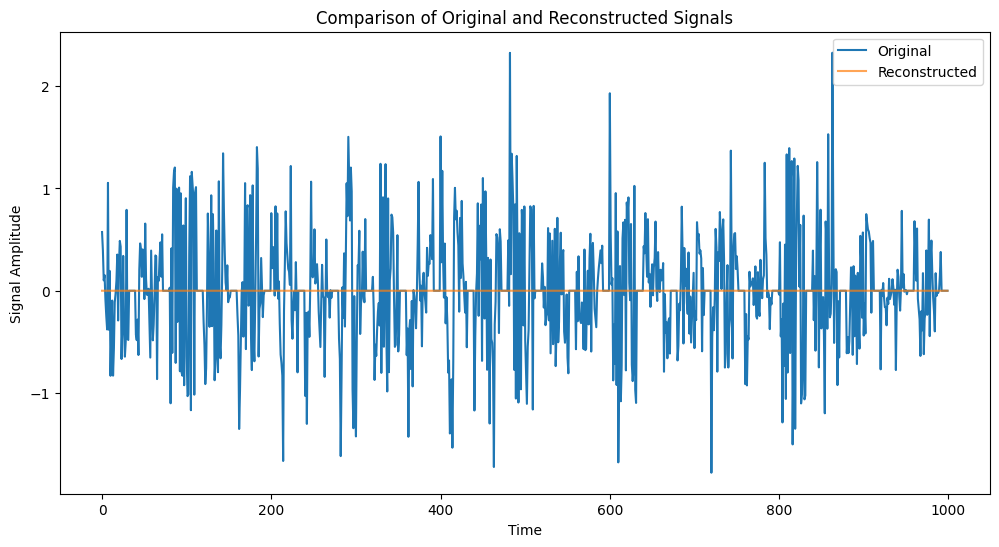

Classification Accuracy: 0.49597024178549287
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       813
           1       0.50      1.00      0.66       800

    accuracy                           0.50      1613
   macro avg       0.25      0.50      0.33      1613
weighted avg       0.25      0.50      0.33      1613



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


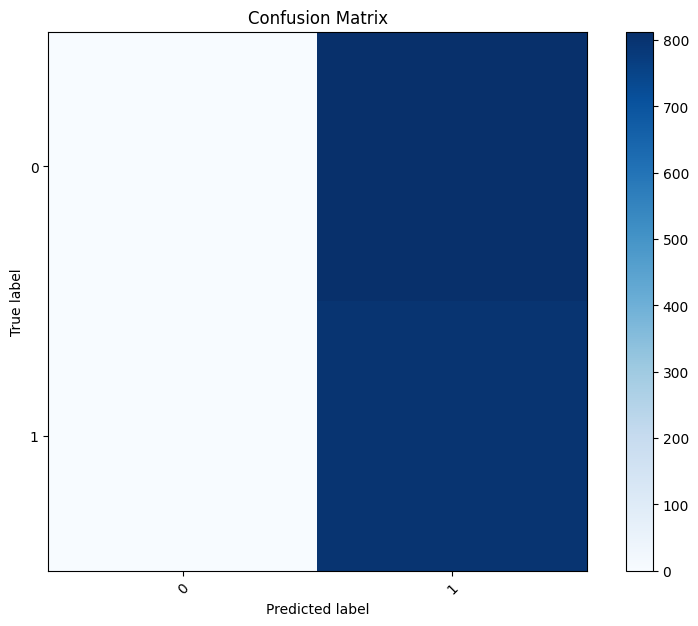

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, Model, losses
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Input, Dense, RepeatVector, TimeDistributed, Flatten
import seaborn as sns
from scipy.fft import fft

# Load and prepare the dataset
def load_and_prepare_data(filepath):
    data = pd.read_csv(filepath)
    data.drop(columns=data.columns[-1], inplace=True)  # Drop last column if irrelevant or empty
    data.fillna(data.mean(), inplace=True)
    return data

# Normalize the data
def normalize_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

# Visualize data
def visualize_data(data, title="Normalized EEG Data"):
    plt.figure(figsize=(15, 7))
    plt.plot(data[:1000])  # Plotting the first 1000 samples for visualization
    plt.title(title)
    plt.xlabel('Sample index')
    plt.ylabel('Normalized amplitude')
    plt.show()

def visualize_histograms(data):
    plt.figure(figsize=(12, 6))
    plt.hist(data, bins=30, alpha=0.75)
    plt.title('Distribution of Features')
    plt.xlabel('Feature Values')
    plt.ylabel('Frequency')
    plt.show()

def visualize_boxplot(data):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=pd.DataFrame(data))
    plt.title('Feature Outliers')
    plt.show()

def visualize_correlation(data):
    correlation_matrix = pd.DataFrame(data).corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

def visualize_spectral_density(data, sampling_rate=256):
    yf = fft(data)
    xf = np.linspace(0.0, sampling_rate/2, len(yf)//2)
    plt.figure(figsize=(12, 6))
    plt.plot(xf, 2.0/len(yf) * np.abs(yf[0:len(yf)//2]))
    plt.title('Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()

def visualize_multi_channel_time_series(data, num_samples=1000):
    plt.figure(figsize=(15, 10))
    num_channels = data.shape[1]
    for i in range(num_channels):
        plt.subplot(num_channels, 1, i + 1)
        plt.plot(data.iloc[:num_samples, i])
        plt.title('Channel ' + str(i + 1))
    plt.tight_layout()
    plt.show()

def visualize_reconstructions(original, reconstructed, samples=1000):
    plt.figure(figsize=(12, 6))
    time = range(samples)
    plt.plot(time, original[:samples], label='Original')
    plt.plot(time, reconstructed[:samples], label='Reconstructed', alpha=0.7)
    plt.title('Comparison of Original and Reconstructed Signals')
    plt.xlabel('Time')
    plt.ylabel('Signal Amplitude')
    plt.legend()
    plt.show()


# Define the Semi-supervised Variational Autoencoder with RNN
class RnnSemiSupervisedVAE(Model):
    def __init__(self, timesteps, features, latent_dim, num_classes):
        super(RnnSemiSupervisedVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.timesteps = timesteps
        self.features = features

        # Encoder with LSTM
        self.encoder = tf.keras.Sequential([
            Input(shape=(timesteps, features)),
            LSTM(128, return_sequences=True),
            LSTM(64),
            Dense(latent_dim * 2 + num_classes)
        ])

        # Decoder with LSTM
        self.decoder = tf.keras.Sequential([
            Dense(64),
            RepeatVector(timesteps),
            LSTM(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            TimeDistributed(Dense(features, activation='sigmoid'))
        ])

    def encode(self, x):
        encoder_output = self.encoder(x)
        z_mean, z_log_var, y_logit = tf.split(encoder_output, num_or_size_splits=[self.latent_dim, self.latent_dim, self.num_classes], axis=1)
        return z_mean, z_log_var, y_logit

    def reparameterize(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs):
        z_mean, z_log_var, y_logit = self.encode(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstruction = self.decode(z)
        return reconstruction, y_logit, z_mean, z_log_var

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            reconstruction, y_logit, z_mean, z_log_var = self(x, training=True)
            reconstruction_loss = tf.reduce_mean(losses.mean_squared_error(x, reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            classification_loss = tf.reduce_mean(losses.sparse_categorical_crossentropy(y, y_logit))
            total_loss = reconstruction_loss + kl_loss + classification_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {'loss': total_loss}

def main():
    filepath = 'features_raw.csv'
    data = load_and_prepare_data(filepath)
    scaled_data = normalize_data(data)
    visualize_data(scaled_data)
    visualize_histograms(scaled_data)
    visualize_boxplot(scaled_data)
    visualize_correlation(scaled_data)
    visualize_spectral_density(scaled_data[:, 0])
    visualize_multi_channel_time_series(pd.DataFrame(scaled_data), 1000)

    labels = np.random.randint(0, 2, size=(scaled_data.shape[0],))
    data_train, data_test, labels_train, labels_test = train_test_split(scaled_data, labels, test_size=0.2, random_state=40)

    timesteps = 10  # Define timesteps based on your dataset and model architecture
    features = data_train.shape[1] // timesteps if data_train.shape[1] % timesteps == 0 else None

    if features is None:
        print("Timesteps do not evenly divide the number of features. Adjusting by padding...")
        extra_features = timesteps - (data_train.shape[1] % timesteps)
        data_train = np.pad(data_train, ((0, 0), (0, extra_features)), 'constant')
        data_test = np.pad(data_test, ((0, 0), (0, extra_features)), 'constant')
        features = data_train.shape[1] // timesteps

    data_train = data_train.reshape(-1, timesteps, features)
    data_test = data_test.reshape(-1, timesteps, features)

    train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).batch(32)
    test_dataset = tf.data.Dataset.from_tensor_slices((data_test, labels_test)).batch(32)

    latent_dim = 10
    num_classes = 2
    vae = RnnSemiSupervisedVAE(timesteps, features, latent_dim, num_classes)
    vae.compile(optimizer='adam')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    vae.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[reduce_lr])

    for test_inputs, test_labels in test_dataset.take(1):  # Taking a single batch from the test set
        reconstructed, _, _, _ = vae(test_inputs)
        visualize_reconstructions(test_inputs.numpy().flatten(), reconstructed.numpy().flatten())

    reconstructed, predicted_logits, _, _ = vae(data_test)
    predicted_labels = np.argmax(predicted_logits, axis=1)

    print("Classification Accuracy:", accuracy_score(labels_test, predicted_labels))
    print(classification_report(labels_test, predicted_labels))
    display_confusion_matrix(labels_test, predicted_labels)

def display_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(true_labels)))
    plt.xticks(tick_marks, np.unique(true_labels), rotation=45)
    plt.yticks(tick_marks, np.unique(true_labels))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    main()